# About

![prjpic](doc/media_main/story.png)

This is the main demo of this repo, it is about a concept study on the MIMII dataset to detect anomalies of machines or machine parts like fans, slider, pump and valves by means of classic machine learning and deep learning methods.

In runs through the essentials to demonstrate the steps
* feature extraction
* indvidual model training within the ensemble
* ensemble evaluation
* summary and scores

For more in depth information and some insights about the decisions we made, take a look at the subnotebooks and utilities as mentioned in the README.

# Imports

In [1]:
#===============================================
# Basic Imports
BASE_FOLDER = './'
TARGET_FOLDER_FE = r'\dataset\extdia_v1_essential' # output folder for ffeat. extraction
# import the repo-local utility py files
%run -i utility\feature_extractor\JupyterLoad_feature_extractor.py
%run -i utility\modeling\JupyterLoad_modeling.py

# feature extraction diagram
%run -i feature_extraction_diagrams\extdia_v1_essential
%run -i utility\extractor_batch.py

# helper
from tqdm.auto import tqdm
import glob
import gc

# sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

feat_ext_folder = os.path.abspath(BASE_FOLDER + TARGET_FOLDER_FE)

load feature_extractor_mother
load feature_extractor_mel_spectra
load feature_extractor_psd
load feature_extractor_ICA2
load feature_extractore_pre_nnFilterDenoise
load extractor_diagram_mother
load Simple_FIR_HP
load TimeSliceAppendActivation
load load_data
Load split_data
Load anomaly_detection_models
Load pseudo_supervised_models
Load tensorflow models
Load detection_pipe
load # extractor diagram V1 essential
load extractor_batch


## General config

To customize the following notebook execution, set the specifications here:

The execution time on a local desktop PC for all four IDs of one machine and one SNR is circa 1 hour. We recommend only executing a set of 4 variations at a time.

In [10]:
#===============================================
# Possible variations
# 
# SNRs = ['6dB', '0dB', 'min6dB']
# machines = ['pump', 'valve', 'fan', 'slider']
# IDs = ['00', '02', '04', '06']

SNRs = ['6dB', 'min6dB']
machines = ['pump', 'valve', 'fan', 'slider']
IDs = ['04', '06']
aug = False

# note: increase n_jobs to max. CPUs you have use all hyperthreading cores (there is no auto detect just now)
n_jobs = 7

## Utility wrapper functions

In [11]:
def feat_ext_process_set(FileFindDict, main_channel=0, sporadic=False, augment=False,FileCountLimit=None, n_jobs=4):
    
    if sporadic:
        dt = 1 # 1 means time slicing 
    else:
        dt = 0
        
    if augment:
        ag = 0 # augment only normal operation
    else:
        ag = -2 # not existing class = no augment
        
    extractor_batch(base_folder= BASE_FOLDER, 
                    target_folder=TARGET_FOLDER_FE, 
                    extdia = extdia_v1_essential, 
                    FileFindDict = FileFindDict,
                    n_jobs = n_jobs,
                    target_class_map = {'abnormal':1, 'normal': 0},
                    FileCountLimit = FileCountLimit,
                    datset_folder_from_base = 'dataset',
                    fHP=120,
                    DeviceType=dt,
                    main_channel = main_channel,
                    augment=ag)
    
    gc.collect()

In [12]:
def find_data_file(SNR, machine, ID):
    '''
    function to find existing feature data files
    '''
    path = glob.glob(BASE_FOLDER 
              + '/dataset/extdia_v1_essential/{}{}{}_EDiaV1HP'.format(machine, SNR, ID) 
              + "*pandaDisc*.pkl", recursive=True)
    
    if len(path) == 0:
        return None
    elif len(path) == 1:
        return path[0]
    else:
        raise Exception('More than one file found:', path)

# Feat Extraction

## Feature extraction diagram

![exdia](doc/media_feature_extraction/exdia_v1_essential.png)
in order to modify the diagram go the class definition:  /feature_extraction_diagrams/extdia_v1_essential.py

### Note to the main_channel
The main channel is picking one microphone out of the 8, 
this can be seen as if the demo version is strictly in working mono
Or a DOA could be used to find the main direction see : feature_extraction_diagrams/A21_DirectionOfArrival_DOA/pyroomacustic_DOA.ipynb

In [13]:
if not find_data_file('6dB', 'pump', '02'):
    ExampleFileFilter = {'SNR': ['6dB'],'machine': ['pump'],'ID': ['02']}
    # create some 
    feat_ext_process_set(ExampleFileFilter,
                        main_channel=2,
                        sporadic = False,
                        augment = True,
                        FileCountLimit= 4,
                        n_jobs=n_jobs)

## Spot Check the output

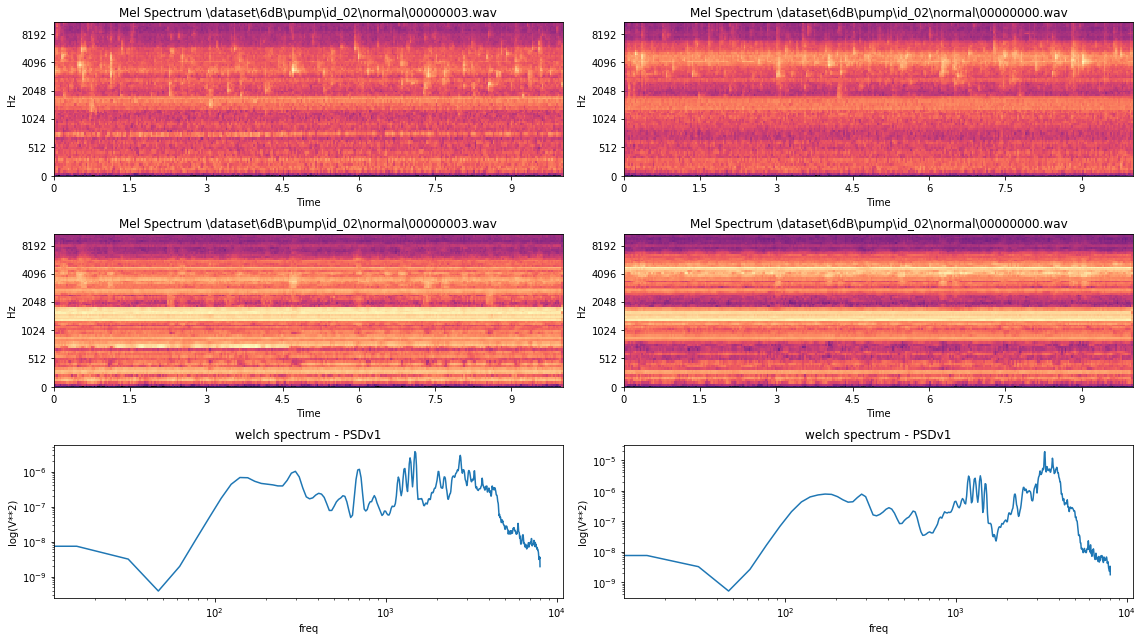

In [14]:
# This code reloads pkl files that have been stored
# in the step above - notice only created files can be loaded
# then a plot is made form n and n+1 output ports
# this cell is ment as a spot check before running the batch that might,
# take much more time !

d_MEL_den = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_den.pkl', "rb" ))
d_MEL_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpMEL_raw.pkl', "rb" ))
d_PSD_raw = pickle.load( open( feat_ext_folder + r'\pump6dB02_EDiaV1HPaug0_outpPSD_raw.pkl', "rb" ))
n1=2
n2=7
plt.figure(figsize=(16,9))
plt.subplot(321)
feature_extractor_from_dict(d_MEL_raw[n1],BASE_FOLDER).plot(False)
plt.subplot(322)
feature_extractor_from_dict(d_MEL_raw[n2],BASE_FOLDER).plot(False)
plt.subplot(323)
feature_extractor_from_dict(d_MEL_den[n1],BASE_FOLDER).plot(False)
plt.subplot(324)
feature_extractor_from_dict(d_MEL_den[n2],BASE_FOLDER).plot(False)
plt.subplot(325)
feature_extractor_from_dict(d_PSD_raw[n1],BASE_FOLDER).plot(True)
plt.subplot(326)
feature_extractor_from_dict(d_PSD_raw[n2],BASE_FOLDER).plot(True)
plt.tight_layout()


## Batch creation of feature data

In [15]:
# Create the batch of feature data
# note: there is still a deepcopy issue you may experience memory leak : https://github.com/BA-HanseML/NF_Prj_MIMII_Dataset/issues/58
for SNR in SNRs:
    for machine in machines:
        # some metaparameters for feature generation according to each machine
        # main_channel is the channel in direction of the machine (according to MIMII-paper setup)
        # for sporadic machinery we use the activation time detection
        if machine == 'valve':
            main_channel = 0
            sporadic = True
        elif machine == 'pump':
            main_channel = 2
            sporadic = False
        elif machine == 'fan':
            main_channel = 4
            sporadic = False
        elif machine == 'slider':
            main_channel = 6
            sporadic = True
        
        for ID in IDs:
            # check if files already exist
            if not find_data_file(SNR, machine, ID):
                BatchFileFilter = {'SNR': SNR,'machine': machine,'ID': ID}
                feat_ext_process_set(BatchFileFilter,
                                    main_channel=main_channel,
                                    sporadic=sporadic,
                                    augment=True,
                                    n_jobs=n_jobs)

# Modeling

In [16]:
class uni_Ensemble(object):
    def __init__(self, SNR, machine, ID, aug=True):
        self.SNR = SNR
        self.machine = machine
        self.ID = ID

        self.weights = [1.3, 1.0, 0.9]
        
        feature_constellation = [('MEL_den', {'function':'frame', 'frames':5}), # Autoencoder MEL spectrum
                          ('MEL_den', {'function':'frame', 'frames':5}), # Isolation Forest MEL spectrum
                          ('PSD_raw', {'function':'flat'}), # Isolation Forest Welch method
                          ('PSD_raw', {'function':'flat'})] # Isolation Forest Welch method
        
        if aug: 
            feature_constellation.append(
                ('PSD_raw', {'function':'flat'}))
            self.weights.append(0.8)
            
        self.tasks = [{
            'path_descr': find_data_file(SNR, machine, ID),
            'feat': feature[1],
            'feat_col':feature[0],
            'SNR':SNR,
            'machine':machine,
            'ID':ID,
            'BASE_FOLDER':BASE_FOLDER
        } for feature in feature_constellation]
        
        self.pipes = [
            Pipe(preprocessing_steps=[(PCA, {'n_components':64}),(StandardScaler, {})], 
                 modeling_step=(uni_AutoEncoder, {'epochs':50}), 
                 pseudo_sup=False), # Autoencoder MEL spectrum
            
            Pipe(preprocessing_steps=[(PCA, {'n_components':64}),(StandardScaler, {})], 
                 modeling_step=(uni_IsolationForest, {'n_estimators':64, 'max_features':4}), 
                 pseudo_sup=False), # Isolation Forest MEL spectrum
            
            Pipe(preprocessing_steps=[(StandardScaler, {})], 
                 modeling_step=(uni_IsolationForest, {'n_estimators':200, 'max_features':1}), 
                 pseudo_sup=False), # Isolation Forest Welch method        
        ]
        
        if aug: self.pipes.append(
            Pipe(preprocessing_steps=[(StandardScaler, {})],
                 modeling_step=(uni_svm, {'C': 0.1, 'degree':3,'kernel':'rbf'}), 
                 pseudo_sup=True) # SVM augmented Welch method
                                 )

    def fit(self):
        for pipe, task in zip(self.pipes, self.tasks):

            # set up the task
            pipe.task = task

            # split data into train and testset
            pipe.split_data()

            # get the data
            print('...loading data')
            data_train, data_test = pipe.get_data()
            print('data loading completed\n\n...preprocessing data')

            # preprocessing
            data_train, data_test = pipe.preprocess(data_train, data_test)
            print('data preprocessing finished\n\n...fitting the model')

            # fitting the model
            pipe.fit_model(data_train)
            print('model fitted successfully\n\n...fitting the prediction scaler')

            # fitting the prediction scaler
            pipe.fit_aggr_score_scaler(data_train, pipe.df_train.path)
            print('prediction scaler fitted successfully\n\n...evaluating model')
            
            # evaluating over ground truth
            pipe.evaluate(data_test)
            print('evaluation successfull, roc_auc:', pipe.roc_auc)

    def predict(self, data, files):
        pass

    def evaluate(self):
        for i, (pipe, weight) in enumerate(zip(self.pipes, self.weights)):
            _, data_test = pipe.get_data()
            data_test = pipe.preprocess_post(data_test)
            if i == 0:
                predictions = pipe.predict_aggr_score(
                    data_test, pipe.df_test.path)*weight
                ground_truth = pipe.median_by_file(
                    pipe.ground_truth, pipe.df_test.path)
            else:
                predictions = np.append(predictions, pipe.predict_aggr_score(
                    data_test, pipe.df_test.path)*weight, axis=1)

        prediction = np.sum(predictions, axis=1)

        return roc_auc_score(ground_truth, prediction)

In [17]:
filepath = 'results.dataframe'
columns = ['SNR', 'machine', 'ID', 'augmented', 'roc_auc']
if os.path.exists(filepath):
    df = pd.read_pickle(filepath)
else:
    df = pd.DataFrame(data=None, columns=columns)

for SNR in SNRs:
    for machine in machines:
        for ID in IDs:
            # check if ensemble result already exists
            # if not, run training and evaluation
            mask = (df.SNR==SNR) & (df.machine==machine) & (df.ID==ID) & (df.augmented==aug)
            if df[mask].shape[0]==0:
                ensemble = uni_Ensemble(SNR, machine, ID, aug=aug)
                ensemble.fit()
                roc_auc = ensemble.evaluate()
                df_tmp = pd.DataFrame(data=[[
                    SNR,
                    machine,
                    ID,
                    aug,
                    roc_auc
                ]], columns=columns)
                df = df.append(df_tmp)
            
            df.to_pickle(filepath)

.//dataset/extdia_v1_essential\pump6dB04_EDiaV1HPaug0_pandaDisc.pkl --> Already Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
Epoch 1/50
727/727 [==============================] - 8s 11ms/step - loss: 0.9711
Epoch 2/50
727/727 [==============================] - 5s 6ms/step - loss: 0.9225
Epoch 3/50
727/727 [==============================] - 5s 6ms/step - loss: 0.8823
Epoch 4/50
727/727 [==============================] - 5s 6ms/step - loss: 0.8473
Epoch 5/50
727/727 [==============================] - 5s 6ms/step - loss: 0.8146
Epoch 6/50
727/727 [==============================] - 5s 6ms/step - loss: 0.7849
Epoch 7/50
727/727 [==============================] - 5s 6ms/step - loss: 0.7590
Epoch 8/50
727/727 [==============================] - 5s 6ms/step - loss: 0.7390
Epoch 9/50
727/727 [==============================] - 5s 7ms/step - loss: 0.7223
Epoch 10/50
727/727 [==============================] - 5s 7ms/step - loss

1128/1128 [==============================] - 7s 6ms/step - loss: 0.6801
Epoch 35/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6794
Epoch 36/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6775
Epoch 37/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6767
Epoch 38/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6760
Epoch 39/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6750
Epoch 40/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6739
Epoch 41/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6733
Epoch 42/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6715
Epoch 43/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6715
Epoch 44/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6703
Epoch 45/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6692
Epoc

1053/1053 [==============================] - 7s 6ms/step - loss: 0.7361
Epoch 6/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.7224
Epoch 7/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.7119
Epoch 8/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.7036
Epoch 9/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.6976
Epoch 10/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.6917
Epoch 11/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.6874
Epoch 12/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.6832
Epoch 13/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.6789
Epoch 14/50
1053/1053 [==============================] - 7s 7ms/step - loss: 0.6751
Epoch 15/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.6716
Epoch 16/50
1053/1053 [==============================] - 7s 6ms/step - loss: 0.6682
Epoch 17

827/827 [==============================] - 6s 7ms/step - loss: 0.7026
Epoch 41/50
827/827 [==============================] - 5s 7ms/step - loss: 0.7018
Epoch 42/50
827/827 [==============================] - 6s 7ms/step - loss: 0.7014
Epoch 43/50
827/827 [==============================] - 5s 6ms/step - loss: 0.7006
Epoch 44/50
827/827 [==============================] - 6s 8ms/step - loss: 0.6998
Epoch 45/50
827/827 [==============================] - 7s 8ms/step - loss: 0.6989
Epoch 46/50
827/827 [==============================] - 6s 8ms/step - loss: 0.6986
Epoch 47/50
827/827 [==============================] - 6s 8ms/step - loss: 0.6977
Epoch 48/50
827/827 [==============================] - 6s 7ms/step - loss: 0.6971
Epoch 49/50
827/827 [==============================] - 6s 8ms/step - loss: 0.6966
Epoch 50/50
827/827 [==============================] - 6s 7ms/step - loss: 0.6959
model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

...evaluati

430/430 [==============================] - 3s 7ms/step - loss: 0.7049
Epoch 14/50
430/430 [==============================] - 3s 7ms/step - loss: 0.7000
Epoch 15/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6959
Epoch 16/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6922
Epoch 17/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6886
Epoch 18/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6853
Epoch 19/50
430/430 [==============================] - 3s 8ms/step - loss: 0.6825
Epoch 20/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6798
Epoch 21/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6773
Epoch 22/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6752
Epoch 23/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6732
Epoch 24/50
430/430 [==============================] - 3s 7ms/step - loss: 0.6709
Epoch 25/50
430/430 [=======

538/538 [==============================] - 3s 6ms/step - loss: 0.7107
Epoch 50/50
538/538 [==============================] - 3s 6ms/step - loss: 0.7101
model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

...evaluating model
evaluation successfull, roc_auc: 0.9130432591176267
.//dataset/extdia_v1_essential\slider6dB06_EDiaV1HPaug0TsSl_pandaDisc.pkl --> Already Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

...evaluating model
evaluation successfull, roc_auc: 0.8284246212461579
.//dataset/extdia_v1_essential\slider6dB06_EDiaV1HPaug0TsSl_pandaDisc.pkl --> Already Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

.

1128/1128 [==============================] - 7s 6ms/step - loss: 0.6959
Epoch 22/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6936
Epoch 23/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6917
Epoch 24/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6893
Epoch 25/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6869
Epoch 26/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6851
Epoch 27/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6843
Epoch 28/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6825
Epoch 29/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6807
Epoch 30/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6787
Epoch 31/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6778
Epoch 32/50
1128/1128 [==============================] - 7s 6ms/step - loss: 0.6764
Epoc

model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

...evaluating model
evaluation successfull, roc_auc: 0.6608377044763996
.//dataset/extdia_v1_essential\valvemin6dB04_EDiaV1HPaug0TsSl_pandaDisc.pkl --> Already Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
model fitted successfully

...fitting the prediction scaler
prediction scaler fitted successfully

...evaluating model
evaluation successfull, roc_auc: 0.9538194444444444
.//dataset/extdia_v1_essential\valvemin6dB06_EDiaV1HPaug0TsSl_pandaDisc.pkl --> Already Done
...loading data
data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
Epoch 1/50
1053/1053 [==============================] - 9s 8ms/step - loss: 0.9172
Epoch 2/50
1053/1053 [==============================] - 6s 6ms/step - loss: 0.8445
Epoch 3/50
1053/1053 [==============================] - 6s 6ms/step - loss: 0.8091

827/827 [==============================] - 5s 6ms/step - loss: 0.6965
Epoch 27/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6954
Epoch 28/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6939
Epoch 29/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6923
Epoch 30/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6916
Epoch 31/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6903
Epoch 32/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6890
Epoch 33/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6876
Epoch 34/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6872
Epoch 35/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6855
Epoch 36/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6852
Epoch 37/50
827/827 [==============================] - 5s 6ms/step - loss: 0.6849
Epoch 38/50
827/827 [=======

data loading completed

...preprocessing data
data preprocessing finished

...fitting the model
Epoch 1/50
430/430 [==============================] - 4s 9ms/step - loss: 0.9560
Epoch 2/50
430/430 [==============================] - 3s 6ms/step - loss: 0.8958
Epoch 3/50
430/430 [==============================] - 3s 6ms/step - loss: 0.8544
Epoch 4/50
430/430 [==============================] - 3s 6ms/step - loss: 0.8226
Epoch 5/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7966
Epoch 6/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7777
Epoch 7/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7637
Epoch 8/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7526
Epoch 9/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7428
Epoch 10/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7348
Epoch 11/50
430/430 [==============================] - 3s 6ms/step - loss: 0.7280
Epoch 12/50

538/538 [==============================] - 3s 6ms/step - loss: 0.6927
Epoch 37/50
538/538 [==============================] - 4s 7ms/step - loss: 0.6916
Epoch 38/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6909
Epoch 39/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6906
Epoch 40/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6889
Epoch 41/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6884
Epoch 42/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6875
Epoch 43/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6868
Epoch 44/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6862
Epoch 45/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6860
Epoch 46/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6848
Epoch 47/50
538/538 [==============================] - 3s 6ms/step - loss: 0.6842
Epoch 48/50
538/538 [=======

In [20]:
df.groupby(by=['augmented', 'SNR']).roc_auc.mean()

augmented  SNR   
False      6dB       0.972909
           min6dB    0.799835
True       6dB       0.971546
           min6dB    0.823585
Name: roc_auc, dtype: float64

In [21]:
df

,SNR,machine,ID,augmented,roc_auc
0,6dB,pump,04,True,0.999600
0,6dB,pump,06,True,0.994137
0,6dB,valve,04,True,0.998958
0,6dB,valve,06,True,0.823264
0,6dB,fan,04,True,0.985302
0,6dB,fan,06,True,0.996700
0,6dB,slider,04,True,0.998390
0,6dB,slider,06,True,0.976013
0,min6dB,pump,04,True,0.973600
0,min6dB,pump,06,True,0.785755


# Summary/ Results